In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping
    

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.models as models
import torch.utils.model_zoo as model
import torchvision.transforms as transforms

import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

True


In [3]:
transform = transforms.Compose([
    transforms.ToTensor()])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [4]:
full_data = VowelConsonantDataset("../input/padhai-hindi-vow-cons-classification/train/train",train=True,transform=transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=60, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=60, shuffle=True)

full_data.get_classes()

{'C0': 0,
 'C1': 1,
 'C2': 2,
 'C3': 3,
 'C4': 4,
 'C5': 5,
 'C6': 6,
 'C7': 7,
 'C8': 8,
 'C9': 9,
 'V0': 10,
 'V1': 11,
 'V2': 12,
 'V3': 13,
 'V4': 14,
 'V5': 15,
 'V6': 16,
 'V7': 17,
 'V8': 18,
 'V9': 19}

In [5]:
test_data = VowelConsonantDataset("../input/padhai-hindi-vow-cons-classification/test/test",train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=60,shuffle=False)

(64, 64, 3)
(64, 64, 3)


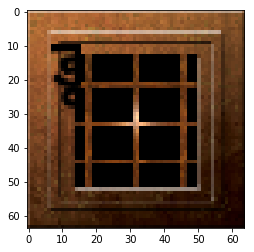

In [6]:
for data in train_loader:
    img,lab = data
    im = np.transpose(img[0].numpy(),(1,2,0))
    
    print(im.shape)
    im = np.squeeze(im)
    print(im.shape)
    plt.imshow(im,)
   # print(img.shape,lab[0])
    break

In [7]:
import torch.nn as nn
from torchvision import models
mod1=models.resnet18()
mod2=models.resnet18()
#mod1.pretrained=True
#mod2.pretrained=True
#mod1.classifier[6]=nn.Linear(4096,10,bias=True)
#mod2.classifier[6]=nn.Linear(4096,10,bias=True)
mod1.fc=nn.Linear(512, 10,bias=True)
mod2.fc=nn.Linear(512,10,bias=True)
print(mod1,mod2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
from tqdm import tqdm_notebook
opt_v = optim.Adam(mod1.parameters())
opt_c = optim.Adam(mod2.parameters())
loss_fn_v = nn.CrossEntropyLoss()
loss_fn_c =  nn.CrossEntropyLoss()
max_epochs = 30
loss_arr= []
st='cuda:0'
mod1.to(st)
mod2.to(st)
import tqdm
for i in tqdm_notebook(range(max_epochs),total=max_epochs,unit='epochs'):
    for data in tqdm_notebook(train_loader,total=len(train_loader),unit='batch'):
        img,lab = data
        img,lab = img.to(st),lab.to(st)
        out_v = mod1(img)
        out_c = mod2(img)
        #print(lab.shape)

        val,ind = torch.max(lab[:,0,:],1)
        val,ind1 = torch.max(lab[:,1,:],1)
        lab_v = ind
        lab_c = ind1
        loss = loss_fn_v(out_v,ind)+loss_fn_c(out_c,ind1)
        
        loss.backward()
        opt_v.step()
        opt_c.step()
        opt_v.zero_grad()
        opt_c.zero_grad()
        del img,lab
        
    print(loss)
    loss_arr.append(loss)   
        
        
        


tensor(3.4952, device='cuda:0', grad_fn=<AddBackward0>)



tensor(3.1241, device='cuda:0', grad_fn=<AddBackward0>)



tensor(2.5999, device='cuda:0', grad_fn=<AddBackward0>)



tensor(2.2850, device='cuda:0', grad_fn=<AddBackward0>)



tensor(1.6301, device='cuda:0', grad_fn=<AddBackward0>)



tensor(1.2065, device='cuda:0', grad_fn=<AddBackward0>)



tensor(1.3817, device='cuda:0', grad_fn=<AddBackward0>)



tensor(1.1943, device='cuda:0', grad_fn=<AddBackward0>)



tensor(0.9976, device='cuda:0', grad_fn=<AddBackward0>)



tensor(0.8873, device='cuda:0', grad_fn=<AddBackward0>)



tensor(1.1162, device='cuda:0', grad_fn=<AddBackward0>)



tensor(0.8940, device='cuda:0', grad_fn=<AddBackward0>)



tensor(1.0190, device='cuda:0', grad_fn=<AddBackward0>)



tensor(1.1735, device='cuda:0', grad_fn=<AddBackward0>)



tensor(0.8538, device='cuda:0', grad_fn=<AddBackward0>)



tensor(0.4352, device='cuda:0', grad_fn=<AddBackward0>)



tensor(0.5968, device='cuda:0', grad_fn=<AddBackward0>)



tensor(0.5927, device='cuda:0', grad_fn=<AddBackward0>)



tensor(0.7689, device='cuda:0', grad_fn=<AddBackward0>)



tensor(0.5509, device='cuda:0', grad_fn=<AddBackward0>)



tensor(0.4971, device='cuda:0', grad_fn=<AddBackward0>)



tensor(0.3857, device='cuda:0', grad_fn=<AddBackward0>)


In [9]:
def evaluation(dataloader,m1,m2):
    total=0
    v=0
    c=0
    for data in dataloader:
        img,lab = data
        img,lab = img.to('cuda:0'),lab.to('cuda:0')
        _,out_v = torch.max(m1(img),1)
        _,out_c = torch.max(m2(img),1)
        _,lab1 = torch.max(lab[:,0,:],1)
        _,lab2 = torch.max(lab[:,1,:],1)
        total += 64
        v += (out_v==lab1).sum().item()
        c += (out_c==lab2).sum().item()
    print('total images:',total)
    print('correct vowels predictions:',v)
    print('correct consonants predictions:',c)
    print('Vowel Accuracy: ',(v/total)*100, '%')
    print('Consonants Accuracy: ',(c/total)*100,'%')
        
        
evaluation(train_loader,mod1,mod2)

total images: 9600
correct vowels predictions: 8618
correct consonants predictions: 8607
Vowel Accuracy:  89.77083333333333 %
Consonants Accuracy:  89.65625 %


In [10]:
#del x,y,l_v,l_c,inputs,labels
torch.cuda.empty_cache()
mod1.eval()
mod2.eval()
pred=[]
name=[]
for i,j in test_loader:
    torch.cuda.empty_cache()
    i=i.to(device)
    #j=j.to(device)
    with torch.no_grad():
        x1=mod1(i)
        y1=mod2(i)
    print(x1,y1)
    _,predi=torch.max(x1,1)
    predi=predi.tolist()
    _,predi2=torch.max(y1,1)
    predi2=predi2.tolist()
    print(predi,predi2)
    for x2,y2,z2 in zip(predi,predi2,j):
        k="V"+str(x2)+"_"+"C"+str(y2)
        pred.append(k)
        name.append(z2)
        #print(k)
    del x1,y1,x2,y2,z2,k

sub=pd.DataFrame({"ImageId":name,"Class":pred})
print(sub)
sub.to_csv('submission.csv',index=False)



tensor([[-4.1977e+00, -1.1811e+01, -7.2678e+00,  1.4961e+01, -1.1048e+01,
         -7.0567e+00, -7.4459e+00, -7.4614e+00, -4.4789e+00,  1.7968e+00],
        [ 1.8938e+00, -7.5389e+00, -3.7718e+00,  1.0445e+01, -9.0595e+00,
         -3.5319e+00, -6.7617e+00, -8.9972e+00, -7.6404e+00,  2.2406e+00],
        [-5.2500e+00,  1.0384e+01, -4.0597e+00, -2.1506e+01, -1.7669e+01,
         -1.2052e+01, -1.6302e+01, -1.3992e+01, -1.9410e+01, -1.3319e+00],
        [-3.2669e+00, -3.3597e+00,  1.2200e+01, -8.4591e+00, -1.2268e+01,
         -6.6198e+00, -1.0804e+01, -1.3300e+01, -8.4229e+00, -2.1314e+00],
        [-4.5522e+00, -1.1356e+01,  1.8279e+01, -1.2821e+01, -2.2118e+01,
         -5.3585e+00, -1.5904e+01, -2.3357e+01, -1.3950e+01, -4.4262e+00],
        [-2.4576e+00, -8.0995e+00, -3.4822e+00, -4.6124e+00, -9.7982e+00,
          9.3886e+00,  3.8709e+00, -8.7350e+00, -7.1690e+00, -6.3244e+00],
        [-7.2409e+00, -8.0118e+00, -7.6565e+00, -4.8567e+00,  3.7660e-03,
         -7.3157e+00, -8.6186e+0